In [4]:
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import PredefinedSplit
import numpy as np


In [3]:
def datasetPrep(dataset):
    #pulls data from csv
    df = read_csv(dataset, header=None)
    
    #add labels to all the columnns 
    df.columns = ['ID', 
                'Label',
                'Statement',
                'Subject',
                'Speaker',
                'Occupation',
                'Location',
                'Party',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts',
                'Context']
    
    #drops columns that are not helpful.
    df = df.drop(['Location',
                # 'Occupation',
                'Barely True Counts',
                'False Counts',
                'Half True Counts',
                'Mostly True Counts',
                'Pants on Fire Counts'], axis=1)
    
    #drops rows that have been labeled "half-true"
    df = df.drop(df[df['Label'] == 'half-true'].index)

    #drops rows with information missing in columns
    df = df.dropna()
    
    #drops rows with duplicates 
    df = df.drop_duplicates()  

    X = df[['Statement',
            'Subject',
            'Speaker',
            'Party',
            'Occupation',
            'Context'
            ]]
        
    Y = df['Label']
    X = X.astype(str)

    # df['Combined Data'] = df['Statement'] + ' ' + df['Subject'] + ' ' + df['Speaker'] + ' ' + df['Party'] + ' ' + df['Occupation'] + ' ' + df['Context']
    # X = df['Combined Data']

    return X, Y 

In [56]:
def TwoClassConversion(outputs):
    outputs = outputs.replace(["barely-true","pants-fire"], "FALSE")
    outputs = outputs.replace(["mostly-true"], "TRUE")
    # outputs = outputs.replace(["mostly-true", "half-true"], "TRUE")
    return outputs

In [4]:
def gausNBFunct(x,y,testX,validX):
    
    count_vect = CountVectorizer()
    xTrainCounts = count_vect.fit_transform(x)
    tfTransformer = TfidfTransformer()
    xTrainTF = tfTransformer.fit_transform(xTrainCounts)
    
    testXCount = count_vect.transform(testX)
    testXTF = tfTransformer.transform(testXCount)
    
    validXCount = count_vect.transform(validX)
    validXTF = tfTransformer.transform(validXCount)
    
    print(xTrainTF.shape)
    gausNB = GaussianNB()
    xClean = xTrainTF.toarray()
    testXTF = testXTF.toarray()
    validXTF = validXTF.toarray()

    nbClf = gausNB.fit(xClean,y)

    return nbClf, testXTF, validXTF
    

In [10]:
def nbModel(pipeline):
    nbc = Pipeline([
    ("recombine", pipeline),  
    ('clf', MultinomialNB())])
    # nbc.fit(x, y)
    return nbc

In [11]:
def svmModel(pipeline):
    svm = Pipeline([
    ("recombine", pipeline),  
    ('clf', SGDClassifier(loss = 'hinge', 
                          penalty='l2',
                          alpha=1e-3, 
                          random_state=42,
                          max_iter=5, 
                          tol=None))])
    #svm.fit(x, y)
    return svm

In [12]:
def svmSVCModel(pipeline):
    svmSVC = Pipeline([
        ("recombine", pipeline),
        ('clf', svm.SVC())
    ])
    return svmSVC
        

In [13]:
def testModel(model, data, output):
       
    predicted = model.predict(data)
    print(classification_report(output, predicted))
    print(confusion_matrix(output, predicted))

In [14]:
def NBClassifying(trainDataset, testDataset, validDataset, parameters):
    
    x,y = datasetPrep(trainDataset)
    y = TwoClassConversion(y)
    
    testx, testy = datasetPrep(testDataset)
    testy = TwoClassConversion(testy)
    
    xValid,yValid = datasetPrep(validDataset)
    yValid = TwoClassConversion(yValid)
    
    model, testx, xValid = testmethod(x,y,testx,xValid)

    print("Default Parameters:")
    testModel(model,testx,testy)
    
    print()
    print("Hyperparameters:")
    hyperParamTuningGridSearch(xValid,yValid,model,testx,testy,parameters)
    
#     pipeline = textVectorising()
#     nbTempModel = nbModel(pipeline)
#     nbTrainedModel = nbTempModel.fit(x,y)
#     testModel(nbTrainedModel, testx, twoYTest)
    


In [2]:
def svmClassifying(trainDataset, testDataset, validDataset,parameters):
    x,y = datasetPrep(trainDataset)
    y = TwoClassConversion(y)
    
    testx, testy = datasetPrep(testDataset)
    testy = TwoClassConversion(testy)
    
    xValid,yValid = datasetPrep(validDataset)
    yValid = TwoClassConversion(yValid)
    
    # pipeline = textVectorising()
    # svmTempModel = svmModel(pipeline)
    
    # svmTrainedModel = svmTempModel.fit(x,y)
    
    print("Regular:")
    
    testModel(svmTrainedModel, testx, twoYTest)
    

    
    print()
    print("Hyperparameters:")
    hyperParamTuningGridSearch(xValid,yValid,svmTempModel,testx,testy,parameters)
    

In [16]:
def svmSVMClassifying(trainDataset, testDataset, validDataset, parameters):
    x,y = datasetPrep(trainDataset)
    y = TwoClassConversion(y)
    
    pipeline = textVectorising()
    svmSVCTempModel = svmSVCModel(pipeline)
    
    svmSVCTrainedModel = svmSVCTempModel.fit(x,y)
    
    testx, testy = datasetPrep(testDataset)
    
    print("Regular:")
    twoYTest = TwoClassConversion(testy)
    testModel(svmSVCTrainedModel, testx, twoYTest)
    
    xValid,yValid = datasetPrep(validDataset)
    yValid = TwoClassConversion(yValid)
    
    print()
    print("Hyperparameters:")
    hyperParamTuningGridSearch(xValid,yValid,svmSVCTempModel,testx,twoYTest,parameters)

In [17]:
def hyperParamTuningGridSearch(x,y,text_clf,testX,testY,parameters):
    
    # print(text_clf.get_params().keys())
        
    # param_grid = { 'recombine__context__kernel': ['linear', 'rbf', 'poly'], 'recombine__context__C': [0.1, 1, 10]  }
    
    # parameters = {
    #     'recombine__context__vect__ngram_range': [(1, 1), (1, 2)],
    #     'recombine__context__tfidf__use_idf': (True, False),
    #     'clf__alpha': (1e-2, 1e-3),
    # }
 
    
    # parameters = list(ParameterGrid(param_grid))
    # print(parameters)

    # param_grid = param_grid,
    
    gsClf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1 )
    gsclf = gsClf.fit(x,y)
    testModel(gsClf, testX, testY)
    print(gsclf.best_params_)
    

In [18]:
def main():
    trainDataset1 = "Dataset/Train csv_version.csv"
    testDataset1 = "Dataset/Test csv_version.csv"
    validDataset1 = "Dataset/Valid csv_version.csv"
    
    # nbParameters = {'clf__class_prior': [None, [0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]],
    #                 'clf__fit_prior': [True, False]
    #                }
    
    nbParameters = {'var_smoothing': np.logspace(0,-9, num=100)}

#     nbParameters = {
    
#     "recombine__context__vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
#     "recombine__context__vect__min_df": (1, 3, 5, 10),
#     "recombine__context__vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
#     "recombine__context__tfidf__norm": ("l1", "l2"),
#     "clf__alpha": np.logspace(-6, 6, 13),
#     }

    # nbParameters = {
    #      'vect__ngram_range': [(1, 1), (1, 2)],
    #      'tfidf__use_idf': (True, False),
    #      'clf__alpha': (1e-2, 1e-3),
    # }

    print("Naive bayes Results")
    NBClassifying(trainDataset1,testDataset1,validDataset1,nbParameters)
    
#     sgdParameters = {
#     'clf__loss': ['hinge', 'log', 'modified_huber', 'perceptron'],
#     'clf__alpha': [0.0001, 0.001, 0.01],
#     'clf__penalty': ['l1', 'l2', 'elasticnet'],
#     'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'clf__max_iter': [1000, 2000, 3000],
#     'clf__tol': [1e-3, 1e-4, 1e-5],
#     'clf__early_stopping': [True, False]
# }
    
#     print()
#     print('SVM Results')
#     svmClassifying(trainDataset1,testDataset1,validDataset1,sgdParameters)
    
    
#     svmSVCParameters = {
#     'recombine__context__vect__ngram_range': [(1, 1), (1, 2)],
#     'recombine__context__vect__max_df': [0.5, 0.75, 1.0],
#     'recombine__context__tfidf__use_idf': [True, False],
#     'recombine__context__tfidf__norm':['l1', 'l2', None],
#     'clf__C': [0.1, 1, 10],
#     'clf__kernel': ['linear', 'rbf']
# }
#     print()
#     print('SVM SVC Results')
#     svmSVMClassifying(trainDataset1,testDataset1,validDataset1,svmSVCParameters)
    
    
# main()

In [59]:
def Stats(dataset, label):
    data = TwoClassConversion(dataset)
    results = data.to_numpy()
    # print(results.shape)
    # print(results[0:4])
    y = np.array([0, 0])
    mylabels = ["TRUE", "FALSE"]
    for i in range(0,len(results)):
        if results[i] == "TRUE":
            y[0] += 1
        elif results[i] == "FALSE":
            y[1] += 1
    print("true: ",y[0]," false: ", y[1])
    plt.pie(y, labels = mylabels)
    plt.title(label)
    plt.show()

true:  2718  false:  3055


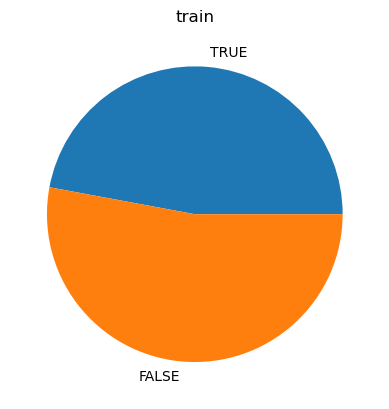

true:  353  false:  389


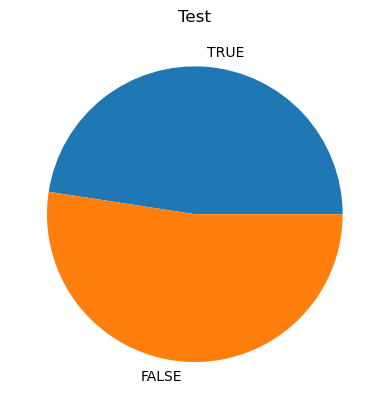

true:  317  false:  429


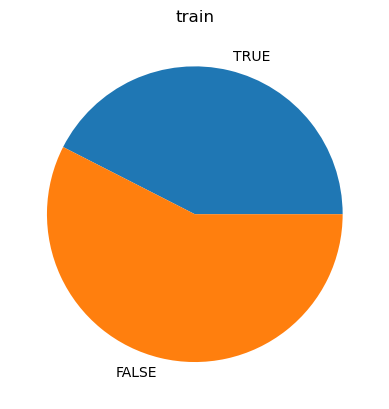

In [60]:
def wtf():
    x, y = datasetPrep("Dataset/Train csv_version.csv")
    Stats(y,"train")
    
    tx, ty = datasetPrep("Dataset/Test csv_version.csv")
    Stats(ty,"Test")
    
    vx, vy = datasetPrep("Dataset/Valid csv_version.csv")
    Stats(vy,"train")
    
wtf()